# Previsão de cancelamentos - ALLREDE

##### Pipeline

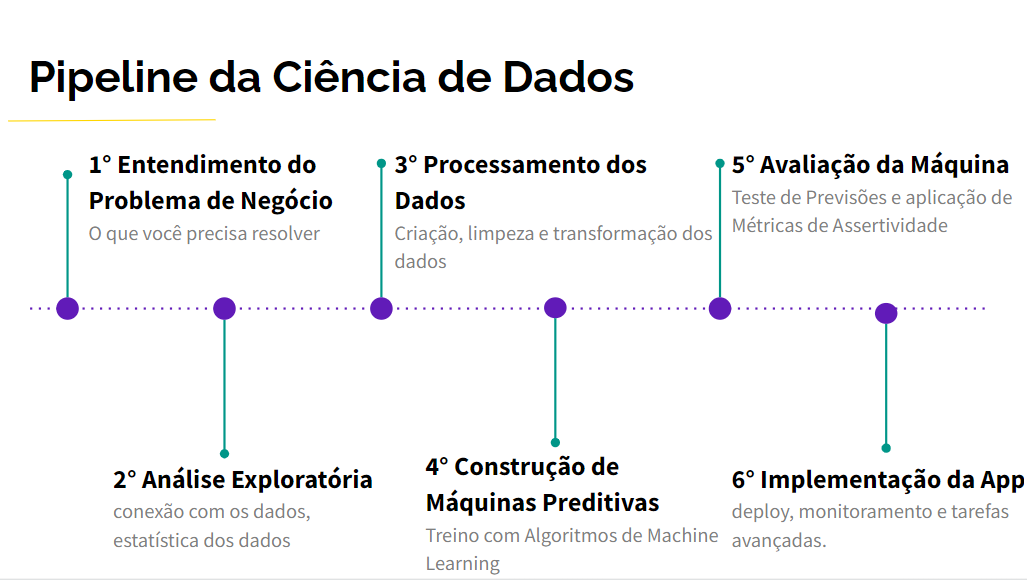

##### Importação das bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,plot_confusion_matrix
from lazypredict.Supervised import LazyClassifier
from imblearn.under_sampling import TomekLinks
from scipy.stats import shapiro
warnings.filterwarnings('ignore')

# **1º** Entendimento do Problema de Negócio

#### Problema da empresa:
> A Allrede tem um dataset com informações de contratos de clientes, com o aumento de cancelamento devemos tentar identificar padrões através de máquinas preditivas para auxiliar nossos colaboradores a ter uma tratativa diferenciada a clientes com possível cancelamento de contrato. A cada linha do dataset e um serviço contrato de clientes, onde pode haver mais serviço para o mesmo cliente.

#### Objetivo:
> Desenvolver uma aplicação onde o colaborador pode selecionar o cliente da base e a máquina pereditiva da um diagnóstico sobre o status do contrato. Se ele tem chances de cancelar ou não.

# **2º** Analise Exploratória

A análise exploratória de dados consiste na técnica de examinar e estudar as características de um conjunto de dados antes de que ele seja submetido a uma aplicação, seja exclusivamente de negócio, estatística ou de aprendizagem de máquina.

*Dicionário do dataset*

Informações sobre as colunas do dataset:

1. cod_servico: Coluna contém os IDs dos serviços.
2. dia_vencimento: Coluna contém o dia dos vencimentos dos serviços.
3. valor: Coluna contém os valores dos serviços contratos pelos clientes.
4. plano: Coluna contém IDs dos plano de serviços contratos pelos clientes.
5. meses_contrato: Coluna contém a quantidade de meses de contrato dos serviços desde sua habilitação do serviço.
6. equipamento: Coluna contém dados sobres os equipamentos instalados nos serviços.
7. qtd_atendimento: Coluna contém a quantidade de atendimentos aberto neste serviço.
8. qtd_ordemservico: Coluna contém a quantidade de os aberta neste serviço.
9. cod_cidade: Coluna contém IDs das cidades onde os serviços estão instalados.
10. contrato: Contém os IDs dos status de contrato dos serviços.

##### Carregando o dataset

In [2]:
dataset_h = pd.read_csv('habilitado.csv',delimiter=';')
dataset_c = pd.read_csv('cancelado.csv',delimiter=';')
dataset = pd.concat([dataset_h,dataset_c])
print(f"Quantidade de total de registros: {dataset.shape[0]}")
print('')
print(f"{dataset['contrato'].value_counts()}")

Quantidade de total de registros: 10000

servico_habilitado    5000
cancelado             5000
Name: contrato, dtype: int64


In [3]:
dataset.columns

Index(['id_cliente_servico', 'dia_vencimento', 'valor', 'plano',
       'meses_contrato', 'qtd_atendimento', 'qtd_ordemservico', 'cidade',
       'contrato'],
      dtype='object')

In [4]:
dataset.set_index('id_cliente_servico',inplace=True)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 56124 to 346872
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dia_vencimento    10000 non-null  object 
 1   valor             10000 non-null  float64
 2   plano             10000 non-null  object 
 3   meses_contrato    10000 non-null  float64
 4   qtd_atendimento   10000 non-null  int64  
 5   qtd_ordemservico  10000 non-null  int64  
 6   cidade            10000 non-null  object 
 7   contrato          10000 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 703.1+ KB


In [6]:
dataset.describe()

,valor,meses_contrato,qtd_atendimento,qtd_ordemservico
count,10000.00,10000.00,10000.00,10000.00
mean,135.68,7.32,9.95,2.23
std,469.94,12.10,17.00,13.76
min,0.00,-1199.00,0.00,0.00
25%,109.90,7.00,4.00,1.00
50%,119.90,8.00,8.00,2.00
75%,139.90,8.00,13.00,2.00
max,32942.01,9.00,1115.00,1060.00


<AxesSubplot: >

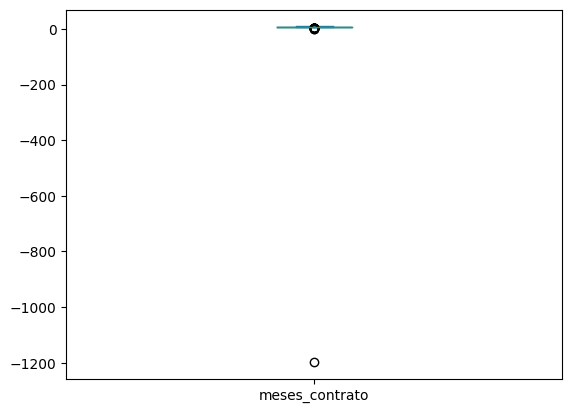

In [7]:
dataset['meses_contrato'].plot.box()

Existe um erro na coluna de meses de contrato onde a valores muito alto e tambem inferior a 0, será tratado no passo 3.

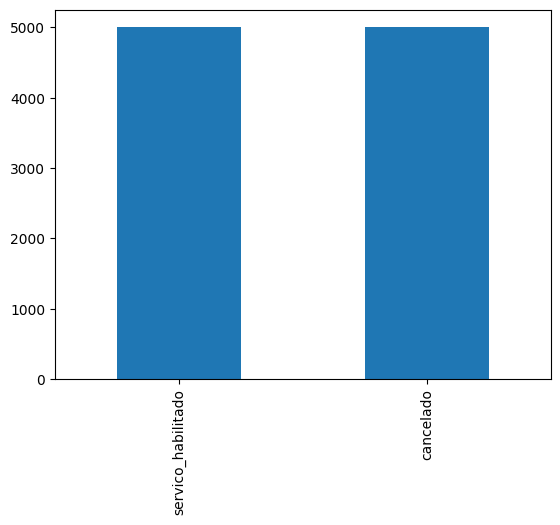

In [8]:
dataset['contrato'].value_counts().plot(kind='bar');

# **3º** Processamento de dados

Processamento de dados é uma série de atividades executadas ordenadamente, que resultará em uma espécie de arranjo de informações, onde inicialmente são coletadas informações, ou dados, que passam por uma organização onde no final será o objetivo que o usuário ou sistema pretende utilizar.

##### Tranformação das colunas para categoria

In [9]:
# Copiando o dataset original para uma nova variavel
dataframe = dataset.copy()

In [10]:
#Criando apenas o dataframe com os valores correto dos meses de contrato.
dataframe = dataframe.loc[(dataframe['meses_contrato'] >= 0) & (dataframe['meses_contrato'] <= 200)]


In [11]:
# Convertendo as colunas que são numeros mais não tem peso, elas geralmente são IDs do dataset original
dataframe['contrato'] = dataframe['contrato'].astype('category')
dataframe['cidade'] = dataframe['cidade'].astype('category')
dataframe['dia_vencimento'] = dataframe['dia_vencimento'].astype('category')
dataframe['plano'] = dataframe['plano'].astype('category')

In [12]:
# Total de registro por contrato do novo dataframe
dataframe['contrato'].value_counts()

servico_habilitado    5000
cancelado             4999
Name: contrato, dtype: int64

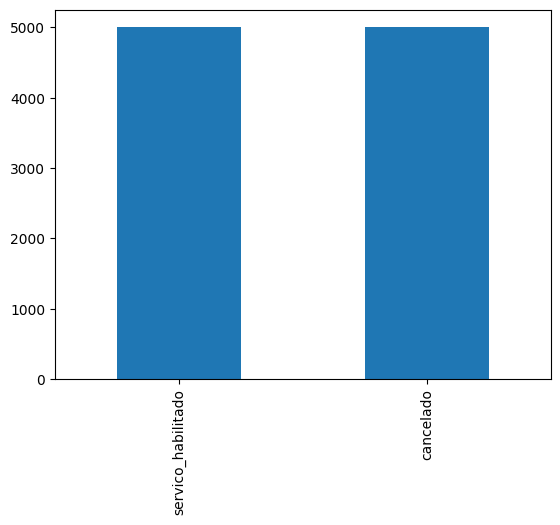

In [13]:
dataframe['contrato'].value_counts().plot.bar();

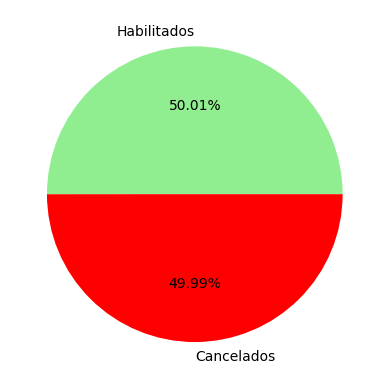

In [14]:
plt.pie(dataframe['contrato'].value_counts(),labels=['Habilitados','Cancelados'],autopct='%1.2f%%',colors=['lightgreen','red'])
plt.show()

In [15]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 56124 to 346872
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   dia_vencimento    9999 non-null   category
 1   valor             9999 non-null   float64 
 2   plano             9999 non-null   category
 3   meses_contrato    9999 non-null   float64 
 4   qtd_atendimento   9999 non-null   int64   
 5   qtd_ordemservico  9999 non-null   int64   
 6   cidade            9999 non-null   category
 7   contrato          9999 non-null   category
dtypes: category(4), float64(2), int64(2)
memory usage: 453.9 KB


O coeficiente de correlação de Pearson é um teste que mede a relação estatística entre duas variáveis contínuas. Se a associação entre os elementos não for linear, o coeficiente não será representado adequadamente.

O coeficiente de correlação de Pearson pode ter um intervalo de valores de +1 a -1. Um valor de 0 indica que não há associação entre as duas variáveis. Um valor maior que 0 indica uma associação positiva. Isto é, à medida que o valor de uma variável aumenta, o mesmo acontece com o valor da outra variável. Um valor menor que 0 indica uma associação negativa. Isto é, à medida que o valor de uma variável aumenta, o valor da outra diminui.

Fonte: [Question Pro](https://www.questionpro.com/blog/pt-br/correlacao-de-pearson/)

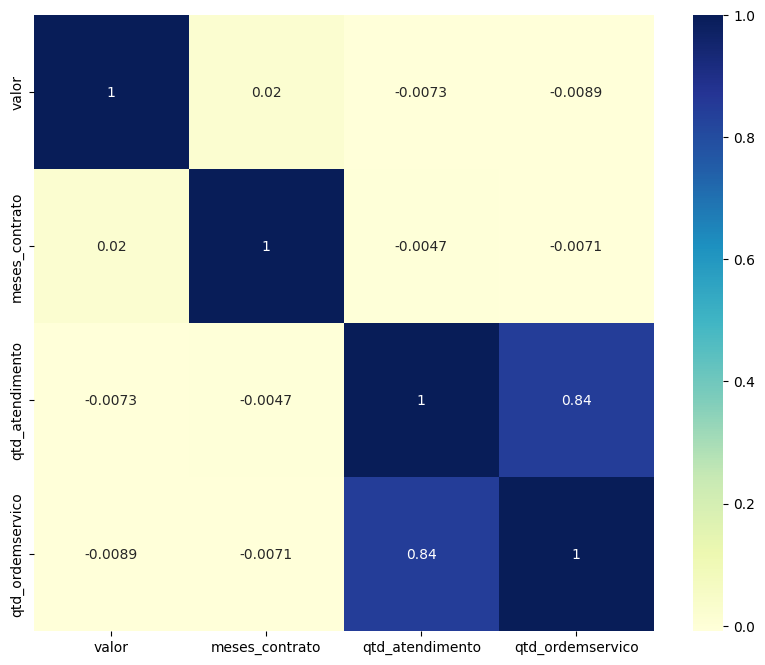

In [16]:
# Correlação de Pearson
fig3, ax3 = plt.subplots(figsize=((10,8)))
sns.heatmap(dataframe.corr(),cmap='YlGnBu',annot=True,ax=ax3)
plt.show()

In [17]:
onehotenconder = OneHotEncoder()
X_cat = dataframe[['dia_vencimento','plano','cidade']]
X_cat = onehotenconder.fit_transform(X_cat).toarray()   

In [18]:
X_cat = pd.DataFrame(X_cat)

In [20]:
X_num = dataframe[['valor','meses_contrato','qtd_atendimento','qtd_ordemservico']]


In [21]:
X_num.reset_index(inplace=True)
del X_num['id_cliente_servico']
X_num

,valor,meses_contrato,qtd_atendimento,qtd_ordemservico
0,19.90,8.00,1,1
1,169.90,9.00,5,1
2,0.00,5.00,19,1
3,119.90,6.00,10,3
4,139.90,4.00,49,3
...,...,...,...,...
9994,0.00,7.00,0,0
9995,0.00,7.00,0,0
9996,0.00,7.00,0,0
9997,0.00,7.00,0,4


In [22]:
X_all = pd.concat([X_cat,X_num],axis=1,ignore_index=True)

In [23]:
min_max = MinMaxScaler()
X = min_max.fit_transform(X_all)

In [24]:
y = dataframe.values[:,-1]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

# 4º Construção de Máquinas Preditivas

In [27]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [28]:
predict = rfc.predict(X_test)

In [29]:
print(classification_report(y_test,predict))

                    precision    recall  f1-score   support

         cancelado       0.85      0.85      0.85      1000
servico_habilitado       0.85      0.85      0.85      1000

          accuracy                           0.85      2000
         macro avg       0.85      0.85      0.85      2000
      weighted avg       0.85      0.85      0.85      2000



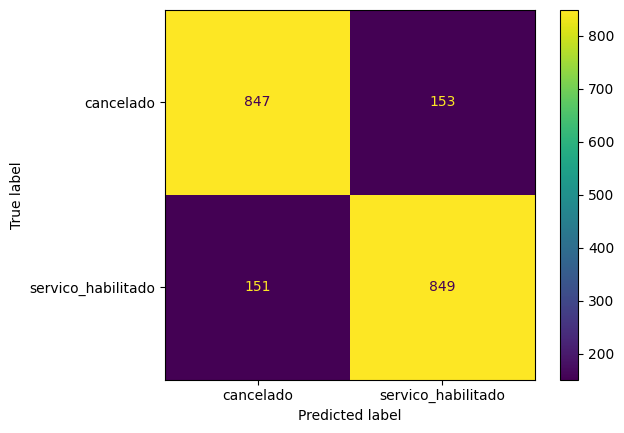

In [30]:
plot_confusion_matrix(rfc,X_test,y_test)

In [36]:
resultado_rfc = []
for i in range(3):
    kfold = KFold(n_splits=10,shuffle=True,random_state=i)
    scores = cross_val_score(rfc,X,y,cv=kfold)
    resultado_rfc.append(scores.mean())
resultado_rfc = np.array(resultado_rfc)

In [37]:
resultado_rfc

array([0.84428739, 0.84398188, 0.84668488])

In [38]:
alpha = 0.5
shapiro(resultado_rfc)

ShapiroResult(statistic=0.8335647583007812, pvalue=0.19743067026138306)

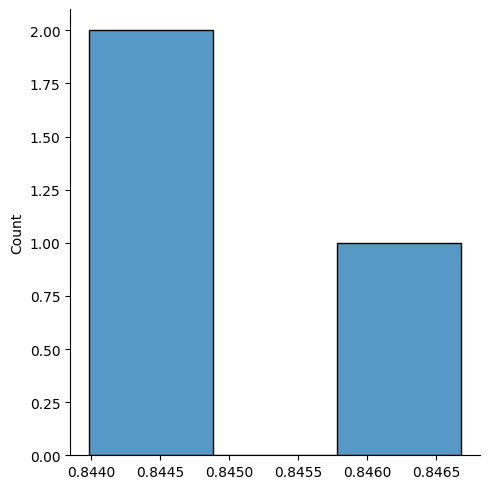

In [39]:
sns.displot(resultado_rfc)